## Imports and System Setup

In [1]:
# Standard libraries
import os
import sys

# Third paty libraries
import pandas as pd


def project_root_path() -> str:
    notebook_root_path = os.path.abspath("")
    return os.path.dirname(os.path.dirname(notebook_root_path))


project_path = project_root_path()
print(f"Project root path: {project_path}")
print(f"Python version: {sys.version}")
sys.path.append(project_path)


# Causality libraries
from causalitydata.analysis.backtest import signalbacktest_df
from causalitydata.analysis.compounding import *
from causalitydata.analysis.evaluate_pnl import *
from causalitydata.data.dataloader import *

Project root path: ~/src/causality-benchmark-data
Python version: 3.9.5 (default, Dec 28 2023, 09:58:15) 
[GCC 12.2.0]


## Configuration

In [2]:
data_root_path = "~/data/causality_benchmark_dataset/common/daily/usa/1500/20240124"

backtest_offset = pd.offsets.BDay(1)
# pd.offsets.Week(1) # pd.offsets.MonthBegin(1) #

# Leaving 3+ years of out-of-sample period:
backtest_end_ts = pd.Timestamp("2021-01-01")  # None #

## Daily Data Preparation

In [3]:
# DataFrames are indexed such that values in a row are observable on the date of the corresponding index.
# For prices this means prices of the given date, while for returns it means that the return is finishing on the index date.

# Close to Close (overnight+intraday) returns are adjusted for splits, dividends, mergers and aquisitions:
ret_cc_df = load_field_df("ret_cc", data_root_path, end_ts=backtest_end_ts)
# Can't trade the close auction based on the same close price.
# Let's generate **adjusted** close to next day 15:45 returns, which can be used to trade in the upcoming close auction:
price_close_df = load_field_df(
    "close", data_root_path, end_ts=backtest_end_ts
)  # close prices are un-adjusted

price_1545_df = load_field_df(
    "154500_close_5m", data_root_path, end_ts=backtest_end_ts
)  # intraday prices are un-adjusted
# Same day prices, no need for onvernight adjustements:
ret_1545c_df = price_close_df / price_1545_df - 1.0
# Close to Close (cc) returns are already adjusted for overnight events, let's use those as a base line:
ret_c1545_df = np.exp(np.log(ret_cc_df + 1.0) - np.log(ret_1545c_df + 1.0)) - 1.0

# Universe is generated using liquidity data of previos days, but it's meant to be the universe one day later, on the index date.
# Contains 1.0 on days when an asset is tradeable, and np.NaN otherwise:
universe_df = load_field_df("universe", data_root_path, shift=0, end_ts=backtest_end_ts)

# All data fields from disk have the same index and same columns:
daily_index = universe_df.index

print(f"Loaded {len(daily_index)} daily records and {len(universe_df.columns)} assets.")

Loaded 3524 daily records and 5360 assets.


## Data Preparation for Trading Bars

Variables names include "bar", in contrast to the daily data above.

In [4]:
# Establish bar_tss, serving as boundaries of trading periods

if backtest_offset in [pd.offsets.Day(1), pd.offsets.BDay(1)]:
    bar_tss = list(daily_index)
else:
    current_ts = daily_index[0] - pd.offsets.Day(1) + backtest_offset
    # List of Timestamps:
    bar_tss = [daily_index[daily_index >= current_ts][0]]
    current_ts += backtest_offset
    while current_ts <= daily_index[-1]:
        bar_tss += [daily_index[daily_index >= current_ts][0]]
        current_ts += backtest_offset

    # Keep unique elements in the list, while staying sorted:
    bar_tss = sorted(list(set(bar_tss)))

assert len(bar_tss) == len(set(bar_tss))

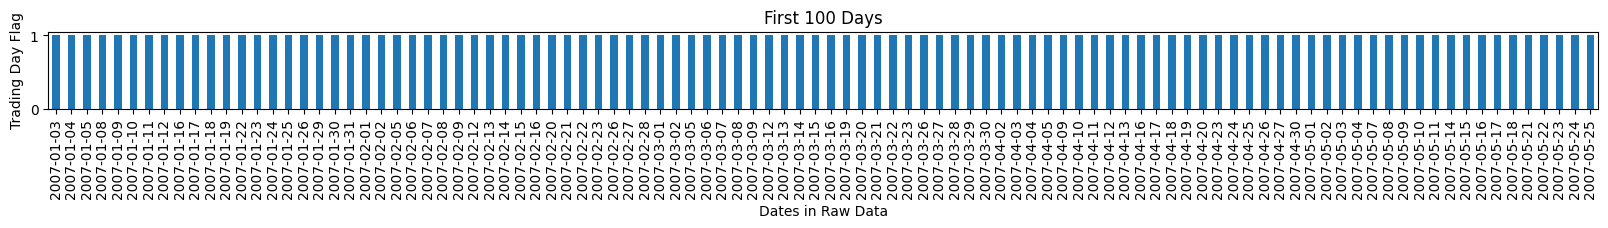

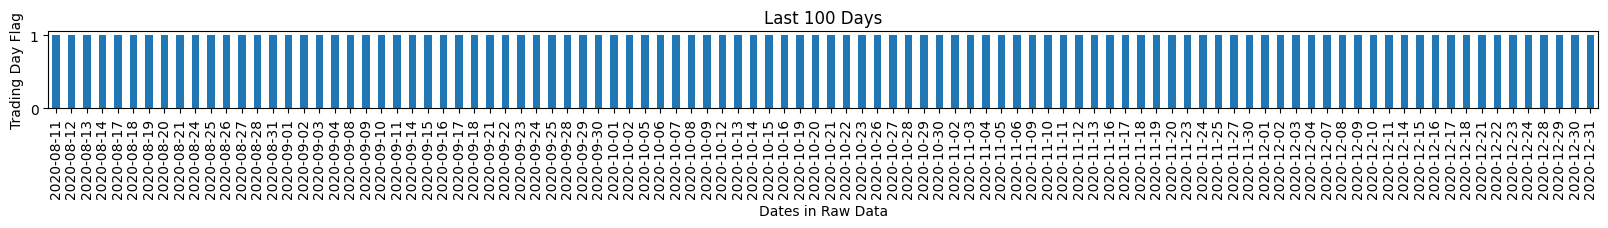

In [5]:
# A bar plot with bars on the trading days, i.e. days in bar_tss

y_values = [(ts in bar_tss) * 1.0 for ts in daily_index]
x_values = daily_index
df = pd.DataFrame(
    y_values, index=[str(ts).split(" ")[0] for ts in daily_index], columns=["Trading"]
)
# Bar plot:
df.iloc[:100, :].plot(
    kind="bar",
    figsize=(20, 1),
    xlabel="Dates in Raw Data",
    ylabel="Trading Day Flag",
    title="First 100 Days",
    legend=False,
)
_ = df.iloc[-100:, :].plot(
    kind="bar",
    figsize=(20, 1),
    xlabel="Dates in Raw Data",
    ylabel="Trading Day Flag",
    title="Last 100 Days",
    legend=False,
)

In [6]:
# Downsample returns between Timestamps in bar_tss, by compounding returns between timestamps in bar_tss.
# Upcoming and observabel returns match, such that we can causally trade signals using the returns of the sime timestamp:
# For example the simplest possible backtest, placing $1 on each asset that lost in the period before will look like:
# pnl_df = (observable_bar_ret_cc_df < 0.0) * upcoming_bar_ret_cc_df

upcoming_bar_ret_cc_df = compound_upcoming_bar_return_cc_df(ret_cc_df, bar_tss)
observable_bar_ret_cc_df = compound_observable_bar_return_cc_df(ret_cc_df, bar_tss)

bar_universe_df = universe_df.loc[bar_tss, :]

In [7]:
# Establish the data used in the trading strategy at Timestamps in bat_tss,
# available at the Timestamp in its index (observable_ prefix)

# Variables observable when trading on the bar_tss dates:
observable_ret_c1545_df = ret_c1545_df.loc[
    bar_tss, :
]  # Can use the current 15:45 price
observable_bar_ret_cc1545_df = compound_ret_df(
    observable_bar_ret_cc_df, ret_c1545_df.loc[bar_tss, :]
)

observable_bar_signal_dfdict = {
    # Return from last daily close to today's 15:45 price:
    "day_ret_c1545": observable_ret_c1545_df,
    # Returns of period bar until previous close, compounded with returns until 15:45 from previous close:
    "bar_ret_cc1545": observable_bar_ret_cc1545_df,
}

for window_i in (
    1,
    2,
    3,
    5,
    21,
    42,
    63,
    int(252 / 2),
    252,
):  # Conveniently sparse windows to reduce correlation
    observable_bar_signal_dfdict[f"bar_ret_cc_{window_i:03d}"] = (
        observable_bar_ret_cc_df.rolling(window=window_i).sum().loc[bar_tss, :]
    )
for window_i in (
    1,
    2,
    3,
    5,
    21,
    42,
    63,
    int(252 / 2),
    252,
):  # Conveniently sparse windows to reduce correlation
    observable_bar_signal_dfdict[f"bar_ret^2_cc_{window_i:03d}"] = (
        observable_bar_ret_cc_df.rolling(window=window_i).sum().loc[bar_tss, :] ** 2.0
    )

In [8]:
# Create a backtest loop, to make trading dacisions on each day in bar_tss:
# This is your place to includ more complexy strategies and backtesting.

# for trade_ts in bar_tss:
#     print(f'Trading the close on {trade_ts}')

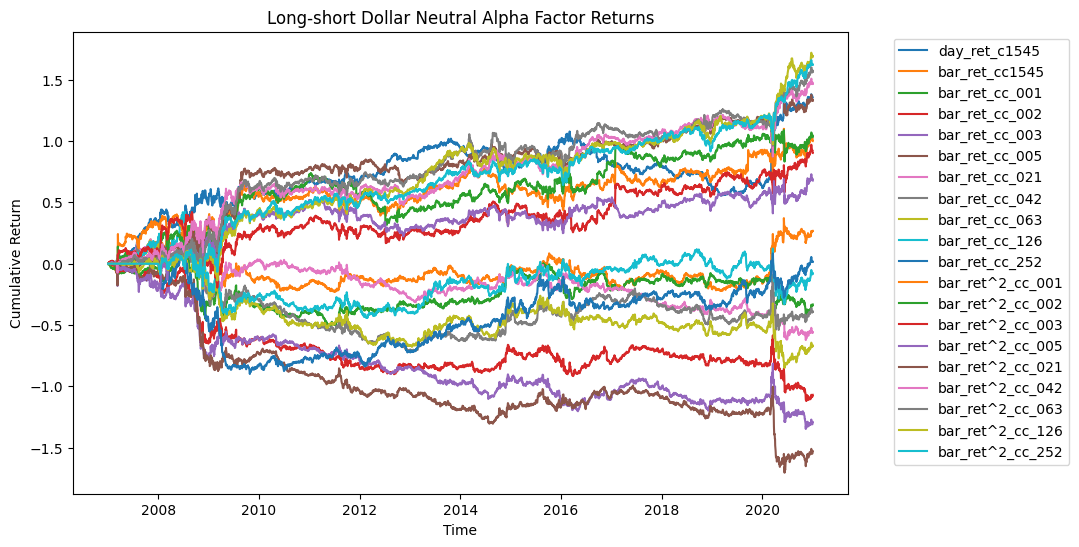

,day_ret_c1545,bar_ret_cc1545,bar_ret_cc_001,bar_ret_cc_002,bar_ret_cc_003,bar_ret_cc_005,bar_ret_cc_021,bar_ret_cc_042,bar_ret_cc_063,bar_ret_cc_126,bar_ret_cc_252,bar_ret^2_cc_001,bar_ret^2_cc_002,bar_ret^2_cc_003,bar_ret^2_cc_005,bar_ret^2_cc_021,bar_ret^2_cc_042,bar_ret^2_cc_063,bar_ret^2_cc_126,bar_ret^2_cc_252
Cumulative PnL,1.356156,0.267688,-0.331764,-1.068736,-1.290332,-1.528236,-0.560381,-0.392193,-0.669823,-0.080427,0.013904,0.999510,1.032054,0.902435,0.677374,1.327602,1.465485,1.565276,1.690078,1.621661
Annual PnL,0.097448,0.019235,-0.023839,-0.076795,-0.092718,-0.109813,-0.040267,-0.028182,-0.048131,-0.005779,0.000999,0.071821,0.074160,0.064846,0.048674,0.095397,0.105304,0.112475,0.121443,0.116527
Average PnL,0.000385,0.000076,-0.000094,-0.000303,-0.000366,-0.000434,-0.000159,-0.000111,-0.000190,-0.000023,0.000004,0.000284,0.000293,0.000256,0.000192,0.000377,0.000416,0.000444,0.000480,0.000460
Maximum PnL,0.162481,0.153557,0.067526,0.062772,0.065552,0.071426,0.082277,0.099035,0.065767,0.064150,0.075894,0.196327,0.176090,0.177716,0.140438,0.109489,0.095750,0.091365,0.086536,0.076186
Minimum PnL,-0.084184,-0.102478,-0.106736,-0.122538,-0.121044,-0.116279,-0.106906,-0.101655,-0.098675,-0.093169,-0.095083,-0.099864,-0.121364,-0.137261,-0.144411,-0.088606,-0.109626,-0.062072,-0.056888,-0.063641
Annual Standard Deviation,0.170550,0.176027,0.159870,0.167153,0.166589,0.171302,0.170708,0.178917,0.178906,0.184787,0.179457,0.227096,0.217896,0.215816,0.211721,0.193320,0.186401,0.180658,0.176296,0.161796
Annual Sharpe Ratio,0.571376,0.109274,-0.149117,-0.459432,-0.556571,-0.641052,-0.235883,-0.157512,-0.269029,-0.031275,0.005567,0.316258,0.340344,0.300467,0.229895,0.493465,0.564935,0.622586,0.688857,0.720205
Sortino Ratio,0.785481,0.136047,-0.177257,-0.534459,-0.651549,-0.731104,-0.278621,-0.184305,-0.316493,-0.036330,0.006394,0.459357,0.461904,0.408386,0.305250,0.693428,0.760149,0.863108,0.972103,0.983114
Maximum Drawdown,-0.524027,-0.487723,-0.662222,-1.140862,-1.364406,-1.745616,-0.845305,-0.961130,-1.059439,-0.866182,-1.094349,-0.361481,-0.421487,-0.616141,-0.303754,-0.323308,-0.340271,-0.323499,-0.310199,-0.298209
Calmar Ratio,0.000734,0.000156,-0.000142,-0.000266,-0.000268,-0.000248,-0.000188,-0.000116,-0.000179,-0.000026,0.000004,0.000785,0.000695,0.000416,0.000633,0.001165,0.001222,0.001373,0.001546,0.001543


In [9]:
# Analyze returns of the alpha factors

pnl_dict = {}

enter_at_stdev = 2.0

for key, signal_df in observable_bar_signal_dfdict.items():

    signal_df = signal_df * bar_universe_df
    trade_ret_df = signalbacktest_df(
        signal_df, upcoming_bar_ret_cc_df, enter_at_stdev=2.0
    )
    pnl_dict[key] = trade_ret_df.sum(axis=1)

strategy_pnl_df = pd.DataFrame(pnl_dict)

plot_pnl(
    strategy_pnl_df,
    title="Long-short Dollar Neutral Alpha Factor Returns",
    ylabel="Cumulative Return",
)
display(calculate_performance_df(strategy_pnl_df))